# Class 5: Machine Learning for Treatment Effects II

- Evaluation of Machine Learning models.
- Bias-variance trade-off.
- Overfitting. Training and Test sets.
- Regularization. Model Selection.
- Hyperparameter Tuning and Cross-validation.
- Random Forests
- Feature Importance and Partial Dependence Plots

## Evaluation of Machine Learning models

In our design and implementation of Machine Learning models for the propensity score, we have been "cheating" once again by comparing the predicted propensities to the true ones, and comparing feasible IPW estimation against a known treatment effect to determine which model was the best. When we face an actual propensity score prediction problem, we don't have access to those elements, so we must find a way to evaluate our models. 

## Bias-variance tradeoff

In a prediction problem, our goal is to obtain the function that characterizes the relationship between the target $Y_i$ and the features $X_i$ as accurately as possible:

$$Y_i = f(X_i) + \varepsilon_i, \quad \varepsilon_i \overset{iid}{\sim} (0,\sigma^2_\varepsilon)$$

Given a loss function $L(Y_i,f(X_i))$, we define the **expected prediction error** for a model $\hat{f}$ as:

$$\text{EPE}(\hat{f}) = \mathbb{E}[L(Y_i,\hat{f}(X_i))]$$

Assume for a moment that $Y_i$ is a scalar so $Y_i = y_i$ and $X_i = x$,  and $L$ is the MSE loss. We can decompose $\text{EPE}(\hat{f})$ into three components:

\begin{align*}
\text{EPE}(x_0) &= \mathbb{E}[(y_0-\hat{f}(x_0))^2|X=x_0]\\
\text{EPE}(x_0) &= \mathbb{E}[(f(x_0)+\varepsilon-\hat{f}(x_0))^2|X=x_0]\\
\text{EPE}(x_0) &= \mathbb{E}[(f(x_0)-\hat{f}(x_0)+\varepsilon)^2|X=x_0]\\
\text{EPE}(x_0) &= \mathbb{E}[(f(x_0)-\hat{f}(x_0))^2+2(f(x_0)-\hat{f}(x_0))\varepsilon+\varepsilon^2|X=x_0]\\
\text{EPE}(x_0) &= \mathbb{E}[(f(x_0)-\hat{f}(x_0))^2|X=x_0]+2\mathbb{E}[(f(x_0)-\hat{f}(x_0))\,\varepsilon|X=x_0]+\mathbb{E}[\varepsilon^2|X=x_0]\\
\text{EPE}(x_0) &= \mathbb{E}[(f(x_0)-\hat{f}(x_0))^2|X=x_0]+0+\sigma^2_\varepsilon\\
\text{EPE}(x_0) &= (f(x_0)-\mathbb{E}[\hat{f}(x_0)|X=x_0])^2 + \mathbb{E}[(\hat{f}(x_0)-\mathbb{E}[\hat{f}(x_0)|X=x_0])^2] + \sigma^2_\varepsilon\\
\text{EPE}(x_0) &= \text{Bias}^2(f(x_0)) + \text{Variance}(f(x_0)) + \text{Irreducible Error}\\
\end{align*}

Let's further assume that our fit is linear, that is, $\hat{f} = X\hat{\beta}$ where $\hat{\beta}$ is a $p$-dimensional vector. Averaging across the sample, the three terms above are equal to:

\begin{align*}
\frac{1}{n}\sum_i \text{EPE}(x_i) = \frac{1}{n}\sum_i (f(x_i)-\mathbb{E}[x_i\hat{\beta}])^2 + \frac{p}{n}\sigma^2_{\varepsilon} + \sigma^2_{\varepsilon}
\end{align*}

Using the simple linear model setting, we see a tradeoff that characterizes essentially all prediction problems: the **bias-variance** trade-off. As we make the model class larger (increase $p$, the number of features and interactions included in the model), we reduce the error through bias reduction, but on the other hand we increase the error because of the larger variance. This applies to tree-based models as well. For example, increasing the depth of the tree will make the model fit the training data better. In fact, if we let the tree grow as large as it can, we can reduce the bias to 0. But the variance of the model will be explosively large since the regions will be a 1:1 mapping from the points used to fit the model themselves.

Every time we deal with a prediction problem, we will have to deal with this trade-off between bias and variance, and we will expand on this in the next section.

## Overfitting. Training and Test sets

We mentioned above that we want our models to minimize the $\text{EPE}$. To obtain a predictor, we collect a sample of observations $S$ which we refer to as the **training set** $\{(Y_i, X_i)\}_{i \in S}$. Let's say we "train" our model and obtain our $\hat{f}_S$. It seems intuitive that, to evaluate the prediction error in the model, we would need to estimate the quantity we want to minimize in the first place. Intuitively, we could compute the sample version of it. This is called the **training error**:

$$\text{ERR}_{S}(\hat{f}_S) = \frac{1}{n}\sum_{i \in S} L(Y_i,\hat{f}_S(X_i))$$

The question is: is this a good estimate of the population $\text{EPE}$? Let's take a closer look. Because we are assuming observations are $iid$ in the population, let's draw a new set of samples $S'$ independent of $S$, $\{(Y_j, X_j)\}_{j \in S'}$ from the same population distribution. We can write the population $\text{EPE}$ as:

$$\text{EPE} = \mathbb{E}[\mathbb{E}[L(Y_j,\hat{f}_S(X_j))|S]]$$

Subtracting $\mathbb{E}[\text{ERR}_{S}(\hat{f}_S)]$ from both sides:

\begin{align*}
\text{EPE} - \mathbb{E}[\text{ERR}_{S}(\hat{f}_S)] &= \mathbb{E}[\mathbb{E}[L(Y_j,\hat{f}_S(X_j))|S]] - \mathbb{E}[\text{ERR}_{S}(\hat{f}_S)]
\end{align*}

Since $S$ and $S'$ are independent, $\text{EPE} = \mathbb{E}[\mathbb{E}[L(Y_j,\hat{f}_S(X_j))|S]] = \mathbb{E}[L(Y_j,\hat{f}_S(X_j))]$ and so:

\begin{align*}
\text{EPE} - \mathbb{E}[\text{ERR}_{S}(\hat{f}_S)] &= \mathbb{E}[\mathbb{E}[L(Y_j,\hat{f}_S(X_j))|S]] - \mathbb{E}[\text{ERR}_{S}(\hat{f}_S)]\\
\text{EPE} - \mathbb{E}[\text{ERR}_{S}(\hat{f}_S)] &= \mathbb{E}[L(Y_j,\hat{f}_S(X_j))] - \mathbb{E}[\text{ERR}_{S}(\hat{f}_S)]\\
\text{EPE} - \mathbb{E}[\text{ERR}_{S}(\hat{f}_S)] &= \mathbb{E}[\text{ERR}_{S'}(\hat{f}_S)] - \mathbb{E}[\text{ERR}_{S}(\hat{f}_S)]\\
\end{align*}

where in the last line we used the fact that since $S'$ is an $iid$ sample independent of $S$, averaging over $S'$ gives the same conditional expectation as a single fresh draw. 

Let's look at the object inside the expectation. We know that $\hat{f}_S$ is obtained by optimizing $\text{ERR}_{S}(f)$ over a class of functions $\mathcal{F}$, so:

$$\hat{f}_S \in \arg\min_{f \in \mathcal{F}} \text{ERR}_{S}(f)$$

which means that $\text{ERR}_{S}(\hat{f}_S) \leq \text{ERR}_{S}(\hat{f}')$ for any other $\hat{f}' \in \mathcal{F}$, in particular $\hat{f}_{S'}$ where:

$$\hat{f}_{S'} \in \arg\min_{f \in \mathcal{F}} \text{ERR}_{S'}(f)$$

Assume for simplicity that $|S| = |S'| = n$ and add the following term to both sides of the inequality:

$$\text{ERR}_{S'}(\hat{f}_S) = \frac{1}{n}\sum_{j \in S'} L(Y_j,\hat{f}_S(X_j))$$

\begin{align*}
\text{ERR}_{S}(\hat{f}_S) &\leq \text{ERR}_{S}(\hat{f}_{S'})\\
\text{ERR}_{S'}(\hat{f}_S) - \text{ERR}_{S}(\hat{f}_S) &\geq \text{ERR}_{S'}(\hat{f}_S) - \text{ERR}_{S}(\hat{f}_{S'})\\
\end{align*}

Taking expectations, we see that the left-hand side of this pointwise inequality matches the last line of the previous derivation:

\begin{align*}
\text{ERR}_{S'}(\hat{f}_S) - \text{ERR}_{S}(\hat{f}_S) &\geq \text{ERR}_{S'}(\hat{f}_S) - \text{ERR}_{S}(\hat{f}_{S'})\\
\mathbb{E}[\text{ERR}_{S'}(\hat{f}_S) - \text{ERR}_{S}(\hat{f}_S)] &\geq \mathbb{E}[\text{ERR}_{S'}(\hat{f}_S) - \text{ERR}_{S}(\hat{f}_{S'})]\\
\text{EPE} - \mathbb{E}[\text{ERR}_{S}(\hat{f}_S)] &\geq \mathbb{E}[\text{ERR}_{S'}(\hat{f}_S)] - \mathbb{E}[\text{ERR}_{S}(\hat{f}_{S'})]\\
\end{align*}

But since the joint distribution of $(S, S')$ is the same as the joint distribution of $(S',S)$, we have that $\mathbb{E}[\text{ERR}_{S'}(\hat{f}_S)] = \mathbb{E}[\text{ERR}_{S}(\hat{f}_{S'})]$ and so:    

\begin{align*}
\text{EPE} - \mathbb{E}[\text{ERR}_{S}(\hat{f}_S)] &\geq \mathbb{E}[\text{ERR}_{S'}(\hat{f}_S)] - \mathbb{E}[\text{ERR}_{S}(\hat{f}_{S'})]\\
\text{EPE} - \mathbb{E}[\text{ERR}_{S}(\hat{f}_S)] &\geq 0\\
\end{align*}

This shows that if we use the same data for training and evaluating our model, we will be underestimating the prediction error regardless of the loss function we choose to obtain $\hat{f}$. When the gap between the two quantities is large, we say that our model is **overfitting** the training data, and the implication is that it does not generalize well to unseen examples. This is intimately related to our error decomposition above: 

<p style="text-align:center;">
<strong>Larger model class/more flexible models, higher chance of overfitting, lower bias, higher variance, typically less generalizability</strong>
</p>

The solution is essentially contained in the above proof: we need to evaluate our model using data from the same population of interest but that was not used for training. This is usually called the **test set**. In practice, we randomly split the observations in our dataset in two: training and test set. A rule of thumb is to reserve between 20 and 30% of the data as test set.

Note that the proof above is completely general and involves the prediction error of the learning procedure. This means that if test set information enters the process that determines $\hat{f}$, then we fall into the same trap. This is usually referred to as overfitting to the test set.

## Regularization and Model Selection

Armed with the learnings from above, let's go back to our propensity score prediction problem. We will simulate a DGP similar to the one before but we will add extra features that are slightly noisier perturbations of our $X_{j}$. Also, we will sample a smaller number of observations (say, 5000) on purpose:

\begin{align*}
i &= 1,\ldots, n\\
X_{ij} &\overset{iid}{\sim} \mathcal{U}(-1, 1), \; j \in \{1,2,3\}\\
{U}_{ijp} &= X_{ij} + \epsilon_{ijh} \quad \epsilon_{ijh} \sim \mathcal{N}(0,1), \; j \in \{1,2,3\}, \; h \in \{1,\ldots,100\}\\
e(X_i) &= 0.1 + 0.85 * \sqrt{\frac{\text{max}\{0,1+X_{2i}+X_{3i}\}}{3}}\\
W_i &\sim Ber(e(X_i))\\
Y_i &= \text{exp}(X_{1i} + X_{2i}) + \text{max}\{0,X_{3i}\} W_i  
\end{align*}

In [2]:
import dgp_simulation
import estimators
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import log_loss
from sklearn.inspection import PartialDependenceDisplay


def disable_sci(ax):
    ax.ticklabel_format(style="plain", axis="both", useOffset=False)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())

np.set_printoptions(suppress=True)

In [3]:
obs_df = dgp_simulation.simulate_dgp(n=5_000, rct=False, num_perturbed_features=100, seed=42)
obs_df.shape

(5000, 306)

In [4]:
obs_df.head()

,W,Y,X1,X2,X3,U1_1,U1_2,U1_3,U1_4,U1_5,...,U3_92,U3_93,U3_94,U3_95,U3_96,U3_97,U3_98,U3_99,U3_100,prop
0,1,2.247810,0.547912,-0.122243,0.717196,-1.277860,2.077927,0.847912,-0.067289,-1.032193,...,0.777594,1.840078,2.587068,-0.413619,0.178436,0.551646,0.669343,-0.147778,-0.614890,0.719772
1,1,1.610325,0.394736,-0.811645,0.951245,0.000048,0.324015,-0.973060,-0.091734,-0.991079,...,2.043785,-0.689329,1.997916,-0.917943,1.766846,-2.022437,1.369642,0.987663,2.098972,0.623883
2,1,2.987414,0.522279,0.572129,-0.743773,-1.226122,2.960226,-0.108721,0.604544,1.081564,...,0.098832,-1.799282,-0.716084,-0.832876,-1.422922,-1.937451,-1.571713,-0.810159,-0.770840,0.546649
3,0,0.699330,-0.099228,-0.258404,0.853530,1.942311,0.429047,0.919135,-1.932521,-0.171612,...,0.227514,-0.355794,2.065099,1.811016,-0.553442,1.395971,1.722310,0.642135,0.285574,0.719806
4,1,2.542769,0.287730,0.645523,-0.113172,0.500221,-0.001925,1.286420,0.813061,-0.626259,...,1.942556,0.045948,1.517341,1.223338,-0.049247,-1.227611,0.486596,-0.111743,-1.038475,0.707488


In [5]:
X_cols = [f"X{j}" for j in range(1, 4)]
U_cols = [f"U{j}_{h}" for j in range(1, 4) for h in range(1, 101)]
C_cols = [f"C{j}" for j in range(1, 4)]
D_cols = [f"D{j}" for j in range(1, 4)]

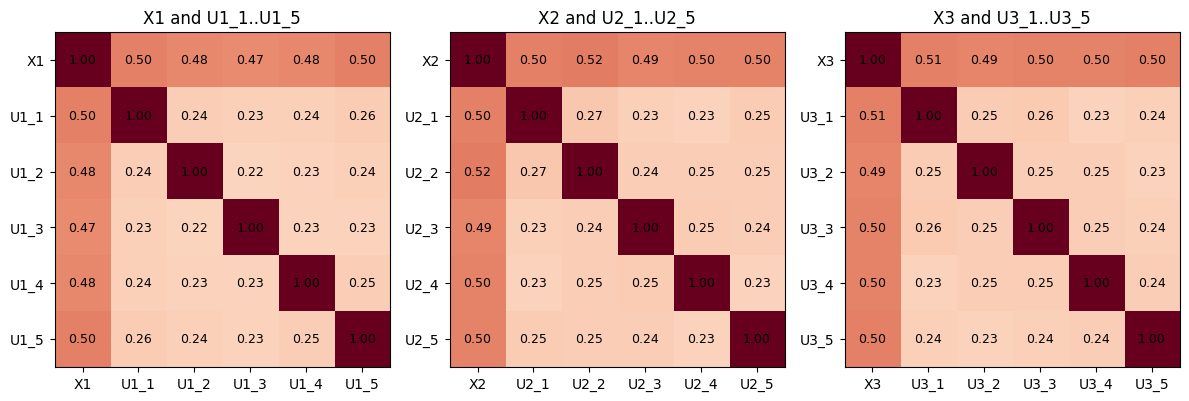

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for j, ax in enumerate(axes, start=1):
    cols = [f"X{j}"] + [f"U{j}_{h}" for h in range(1, 6)]
    corr = obs_df[cols].corr()
    im = ax.imshow(corr, cmap="RdBu_r", vmin=-1, vmax=1)
    ax.set_xticks(range(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_yticks(range(len(cols)))
    ax.set_yticklabels(cols)
    for i in range(len(cols)):
        for k in range(len(cols)):
            ax.text(k, i, f"{corr.iloc[i, k]:.2f}", ha="center", va="center", fontsize=9)
    ax.set_title(f"X{j} and U{j}_1..U{j}_5")
#plt.colorbar(im, ax=axes, shrink=0.6)
plt.tight_layout()
plt.show()

Let's fit a logistic regression model. First, we will split our observations into train and test.

In [7]:
train_df, test_df = train_test_split(obs_df, test_size=0.2, random_state=42)

In [8]:
train_df.describe()

,W,Y,X1,X2,X3,U1_1,U1_2,U1_3,U1_4,U1_5,...,U3_92,U3_93,U3_94,U3_95,U3_96,U3_97,U3_98,U3_99,U3_100,prop
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.539000,1.535726,-0.004255,-0.011048,-0.001298,0.029087,0.022137,-0.000930,-0.029833,-0.029836,...,0.008131,-0.008283,-0.012382,-0.008999,0.017746,-0.010593,0.013805,-0.009194,-0.014741,0.541091
std,0.498539,1.232049,0.576071,0.576085,0.568584,1.152336,1.156054,1.132244,1.159923,1.151117,...,1.153133,1.161682,1.140463,1.141475,1.150460,1.138493,1.169758,1.161478,1.161743,0.232027
min,0.000000,0.142097,-0.999371,-0.999750,-0.999974,-3.562404,-4.372863,-4.666382,-4.272009,-4.166912,...,-3.986072,-4.145345,-3.920447,-3.889857,-3.579982,-3.872814,-3.813923,-3.618296,-3.853054,0.100000
25%,0.000000,0.668705,-0.510085,-0.518521,-0.494230,-0.769112,-0.758753,-0.771512,-0.790934,-0.831322,...,-0.761923,-0.780963,-0.784046,-0.812402,-0.765292,-0.768360,-0.761783,-0.810563,-0.815758,0.414255
50%,1.000000,1.186170,-0.014855,-0.005481,0.010636,0.019325,0.056191,-0.010581,-0.029379,-0.039510,...,0.025592,-0.014890,-0.014502,-0.011471,0.028982,-0.011673,0.040182,-0.028388,-0.007359,0.587248
75%,1.000000,1.980631,0.493526,0.479035,0.482469,0.823966,0.805604,0.752255,0.755746,0.765415,...,0.803310,0.780796,0.769433,0.746120,0.801791,0.749413,0.796027,0.797485,0.759648,0.719062
max,1.000000,7.689858,0.999954,0.998780,0.999895,3.857670,4.628126,3.942527,3.923276,4.413794,...,3.738462,3.599954,3.858262,3.637198,4.001925,3.863128,3.870847,4.472533,3.917967,0.946225


In [9]:
test_df.describe()

,W,Y,X1,X2,X3,U1_1,U1_2,U1_3,U1_4,U1_5,...,U3_92,U3_93,U3_94,U3_95,U3_96,U3_97,U3_98,U3_99,U3_100,prop
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.531000,1.606961,0.005814,0.018985,0.000189,0.032496,-0.012931,0.008519,0.046229,0.013825,...,-0.061724,-0.001321,0.008300,-0.016126,0.027805,0.003778,0.043273,-0.049528,-0.021837,0.551721
std,0.499288,1.256571,0.585310,0.579281,0.580985,1.140739,1.159420,1.165784,1.119434,1.157518,...,1.177872,1.121305,1.158729,1.126956,1.170688,1.132776,1.244624,1.116468,1.168448,0.226362
min,0.000000,0.142147,-0.997453,-0.994741,-0.998858,-3.393205,-4.098007,-4.057742,-3.251195,-3.518994,...,-4.054541,-3.841182,-3.981811,-3.397628,-4.580018,-3.793774,-3.891913,-3.560575,-3.882543,0.100000
25%,0.000000,0.675068,-0.480189,-0.486057,-0.497130,-0.695360,-0.812817,-0.774850,-0.695981,-0.775633,...,-0.927595,-0.811084,-0.744195,-0.801154,-0.785043,-0.749667,-0.810974,-0.775626,-0.832122,0.434869
50%,1.000000,1.262387,0.008848,0.037472,-0.003851,0.037706,0.011322,-0.008034,0.021116,0.041191,...,-0.088898,0.011619,0.004590,-0.024446,0.028166,-0.026713,0.045065,-0.037855,-0.005774,0.596243
75%,1.000000,2.105367,0.531022,0.526606,0.509614,0.783508,0.758215,0.850844,0.772047,0.793672,...,0.733424,0.749249,0.830110,0.735448,0.829978,0.772509,0.848215,0.723172,0.763457,0.714039
max,1.000000,7.780265,0.998818,0.997938,0.999430,3.117156,3.340656,3.174874,3.523964,3.388107,...,3.674037,4.379246,3.695686,3.767826,3.315158,3.421024,4.251993,3.565017,3.749603,0.947578


Training and test sets look similar, which is good. Let's first fit a logistic model just on all the $X_j$ and evaluate the training and test losses.

In [10]:
prop_model_logistic = LogisticRegression(C=np.inf).fit(train_df[X_cols], train_df['W'])
train_df['prop_pred_logistic'] = prop_model_logistic.predict_proba(train_df[X_cols])[:,1]
test_df['prop_pred_logistic'] = prop_model_logistic.predict_proba(test_df[X_cols])[:,1]

c:\Users\mati_\Desktop\ml-uba-private\ml.ci.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1170: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [11]:
{'training_loss': log_loss(train_df['W'], train_df['prop_pred_logistic']),
 'test_loss': log_loss(test_df['W'], test_df['prop_pred_logistic'])}

{'training_loss': 0.5749166970308938, 'test_loss': 0.5932224278692454}

We have this result as a benchmark. Let's now fit a logistic model on all the $U_{jh}$.

In [12]:
prop_model_logistic_U = LogisticRegression(C=np.inf).fit(train_df[U_cols], train_df['W'])
train_df['prop_pred_logistic_U'] = prop_model_logistic_U.predict_proba(train_df[U_cols])[:,1]
test_df['prop_pred_logistic_U'] = prop_model_logistic_U.predict_proba(test_df[U_cols])[:,1]

c:\Users\mati_\Desktop\ml-uba-private\ml.ci.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1170: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [16]:
{'training_loss': log_loss(train_df['W'], train_df['prop_pred_logistic_U']),
 'test_loss': log_loss(test_df['W'], test_df['prop_pred_logistic_U'])}

{'training_loss': 0.539152691710862, 'test_loss': 0.6535664156525466}

What if we fit on both the $X_j$ and the $U_{jh}$?

In [17]:
prop_model_logistic_U_X = LogisticRegression(C=np.inf).fit(train_df[X_cols + U_cols], train_df['W'])
train_df['prop_pred_logistic_U_X'] = prop_model_logistic_U_X.predict_proba(train_df[X_cols + U_cols])[:,1]
test_df['prop_pred_logistic_U_X'] = prop_model_logistic_U_X.predict_proba(test_df[X_cols + U_cols])[:,1]

c:\Users\mati_\Desktop\ml-uba-private\ml.ci.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1170: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [18]:
{'training_loss': log_loss(train_df['W'], train_df['prop_pred_logistic_U_X']),
 'test_loss': log_loss(test_df['W'], test_df['prop_pred_logistic_U_X'])}

{'training_loss': 0.5356380175416161, 'test_loss': 0.6528979688115635}

It is evident that including the $U_{jh}$ in the specification is making the prediction error significantly worse. In this simulated setting, it is obvious why: the propensity scores are a function of the $X_j$ only; the $U_{jh}$ are noise. What is worse is that the noise is not harmless. We are including extra features that are correlated with $X_j$ and absorb part of the relationship between the $X_j$ and $e(X)$. By adding them, we are increasing the model class gaining nothing in terms of bias, and we are losing generalization power because we are overfitting to the training set.

In a world where we don't know or don't want to assume the relationship between each of the features and the target, how can we deal with a problem like this? How do we select which variables to include in a data-driven way? One option would be to try out all possible combinations of features and choose the one that minimizes the test set. However, this can become infeasible pretty quickly.

What if we "penalized" the fit for including variables that don't add predictive power, and simply increase variance? This approach is very common and it is called **Regularization**. In the Linear and Logistic Regression cases, this consists of adding a penalty term to the loss function:

$$L(Y_i,f(X_i);\lambda,\alpha) = \sum_i \left\{W_i x_i\beta - \text{log}\left(1+ \text{exp}(x_i\beta)\right)\right\} + \lambda\left(\alpha ||\beta||_1 + (1-\alpha) ||\beta||^2_2\right)$$

where $\lambda > 0$, $\alpha \in [0,1]$,  $\beta \in \mathbb{R}^{p+1}$, $\beta_0$ is the model constant, and $||\beta||_1 = \sum_{j=1}^p |\beta_j|$ and $||\beta||_2^2 = \sum_{j=1}^p \beta_j^2$.

Let's analyze this new loss function. The new term increases our loss as the coefficients $\beta$ grow in size. Therefore, including this penalty will lead to the solution having smaller coefficients. $\lambda$ controls the size of the penalty. The larger the value of $\lambda$, the smaller we expect the coefficients to be.

Inside the penalty, the first term penalizes the $\mathcal{L}_1$-norm of the coefficients and the second term penalizes the $\mathcal{L}_2$-norm. Note that the model intercept is not penalized. $\alpha$ controls the relative weight of the two penalties. The special case of $\alpha = 0$, where we only penalize the $\mathcal{L}_2$-norm, is usually called **Ridge Regression**. The special case of $\alpha = 1$, where we only penalize the $\mathcal{L}_1$-norm, is usually called **LASSO Regression**. These are the most utilized forms of regularization. When $\alpha \in (0,1)$, we penalize a bit of both, in what's called an **Elastic-Net Regression**.

Both Ridge and Lasso have this shrinking effect, but they have very different implications. Let's see why by comparing each fit.

Note: It is usually recommended to standardize the variables before fitting a regularized regression as the result is not invariant to the scale of the variables. Since all variables in our dataset have a similar scale, we will skip this step.

In [29]:
prop_model_logistic_U_ridge = LogisticRegression(C=0.05, l1_ratio=0, solver='saga', max_iter=1000).fit(train_df[U_cols], train_df['W'])
train_df['prop_pred_logistic_U_ridge'] = prop_model_logistic_U_ridge.predict_proba(train_df[U_cols])[:,1]
test_df['prop_pred_logistic_U_ridge'] = prop_model_logistic_U_ridge.predict_proba(test_df[U_cols])[:,1]

prop_model_logistic_U_lasso = LogisticRegression(C=0.05, l1_ratio=1, solver='saga', max_iter=1000).fit(train_df[U_cols], train_df['W'])
train_df['prop_pred_logistic_U_lasso'] = prop_model_logistic_U_lasso.predict_proba(train_df[U_cols])[:,1]
test_df['prop_pred_logistic_U_lasso'] = prop_model_logistic_U_lasso.predict_proba(test_df[U_cols])[:,1]

In [25]:
prop_model_logistic_U.coef_[0][0:20]

array([-0.09122605,  0.00927487, -0.02553753, -0.02085997,  0.02886738,
        0.0482061 ,  0.00205554,  0.01437935, -0.02627159,  0.00068407,
       -0.03419254, -0.03752437, -0.01885941,  0.01132618,  0.00375781,
       -0.02557525,  0.0362489 , -0.0517534 ,  0.10235973,  0.03236365])

In [30]:
prop_model_logistic_U_ridge.coef_[0][0:20]

array([-0.08737079,  0.00854556, -0.02481392, -0.01996031,  0.02817924,
        0.04607027,  0.00227606,  0.01351972, -0.02507742,  0.00122008,
       -0.03310785, -0.03659635, -0.01764633,  0.0103817 ,  0.00375738,
       -0.02523258,  0.03440497, -0.04998001,  0.09873825,  0.03111879])

In [33]:
prop_model_logistic_U_lasso.coef_[0][0:20]

array([-0.05265191,  0.        , -0.00706663,  0.        ,  0.00389831,
        0.01259774,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.0069347 , -0.01598929,  0.        ,  0.        ,  0.        ,
       -0.01094166,  0.00129796, -0.01699118,  0.07186124,  0.00636272])

In [34]:
{'l1_norm_no_penalty': np.sum(np.abs(prop_model_logistic_U.coef_)),
 'l1_norm_ridge': np.sum(np.abs(prop_model_logistic_U_ridge.coef_)),
 'l1_norm_lasso': np.sum(np.abs(prop_model_logistic_U_lasso.coef_))}

{'l1_norm_no_penalty': np.float64(10.100160431170318),
 'l1_norm_ridge': np.float64(9.73375973036775),
 'l1_norm_lasso': np.float64(3.9257608988378516)}

In [35]:
{'l2_norm_no_penalty': np.sum(np.square(prop_model_logistic_U.coef_)),
 'l2_norm_ridge': np.sum(np.square(prop_model_logistic_U_ridge.coef_)),
 'l2_norm_lasso': np.sum(np.square(prop_model_logistic_U_lasso.coef_))}

{'l2_norm_no_penalty': np.float64(0.5249384267399625),
 'l2_norm_ridge': np.float64(0.4876546802429159),
 'l2_norm_lasso': np.float64(0.1710968885900518)}

In [36]:
{'training_loss': log_loss(train_df['W'], train_df['prop_pred_logistic_U']),
 'test_loss': log_loss(test_df['W'], test_df['prop_pred_logistic_U'])}

{'training_loss': 0.539152691710862, 'test_loss': 0.6535664156525466}

In [37]:
{'training_loss': log_loss(train_df['W'], train_df['prop_pred_logistic_U_ridge']),
 'test_loss': log_loss(test_df['W'], test_df['prop_pred_logistic_U_ridge'])}

{'training_loss': 0.5391956045226212, 'test_loss': 0.6498631195487994}

In [38]:
{'training_loss': log_loss(train_df['W'], train_df['prop_pred_logistic_U_lasso']),
 'test_loss': log_loss(test_df['W'], test_df['prop_pred_logistic_U_lasso'])}

{'training_loss': 0.5512744448336946, 'test_loss': 0.6135023047081918}

Let's see something interesting to understand better what the implications of Ridge are on collinear variables. Let's add two exact copies of $X_j$ called $C_j$ and $D_j$ for $j \in \{1,2,3\}$:     

In [39]:
train_df[['C1','C2','C3']] = train_df[['X1','X2','X3']]
train_df[['D1','D2','D3']] = train_df[['X1','X2','X3']]
test_df[['C1','C2','C3']] = test_df[['X1','X2','X3']]
test_df[['D1','D2','D3']] = test_df[['X1','X2','X3']]

In [40]:
prop_model_logistic.coef_

array([[0.02551461, 1.35605053, 1.3750863 ]])

In [41]:
prop_model_logistic_X_C = LogisticRegression(C=10000, l1_ratio=0).fit(train_df[X_cols + C_cols], train_df['W'])
xc = prop_model_logistic_X_C.coef_
xc

array([[0.01265535, 0.67814473, 0.68837821, 0.01265535, 0.67814473,
        0.68837821]])

In [42]:
xc[0][0] + xc[0][3], xc[0][1] + xc[0][4], xc[0][2] + xc[0][5]

(np.float64(0.02531069824720385),
 np.float64(1.356289465178374),
 np.float64(1.3767564147807778))

In [43]:
prop_model_logistic_X_C_D = LogisticRegression(C=10000, l1_ratio=0).fit(train_df[X_cols + C_cols + D_cols], train_df['W'])
xcd = prop_model_logistic_X_C_D.coef_
xcd

array([[0.00841159, 0.4517007 , 0.45871968, 0.00841159, 0.4517007 ,
        0.45871968, 0.00841159, 0.4517007 , 0.45871968]])

In [44]:
xcd[0][0] + xcd[0][3] + xcd[0][6], xcd[0][1] + xcd[0][4] + xcd[0][7], xcd[0][2] + xcd[0][5] + xcd[0][8]

(np.float64(0.025234782004404627),
 np.float64(1.3551020881853475),
 np.float64(1.3761590272196351))

We see how in the presence of perfectly collinear variables, Ridge "divides" the predictive power of one variable (represented by the coefficient) into all the collinear variables entering the model. This turns out to be the unique solution of Ridge in the presence of perfect collinearity, while only being one of infinite solutions in the non-regularized case.

## Hyperparameter Tuning and Cross-Validation 

Regularization is a really useful tool to mitigate the problem of overfitting. However, even it the simple case of Linear and Logistic regression algorithms, it also adds a number of choices we need to make, and we want them to be as little discretionary as possible. When fitting a regularized model like the one above, we need to choose values for $\lambda$ and $\alpha$. In a Machine Learning algorithm, elements like $\lambda$ and $\alpha$ are called **hyperparameters**, they don't define the model itself (unlike the parameters, for example $\beta$), but they affect the algorithm in different ways. In a decision tree algorithm, for example, the maximum depth of the tree is a hyperparameter.   

Choosing $\alpha$ amounts to choosing between Ridge, LASSO or something in between. In the case of $\alpha$, we might really want to perform feature selection, so under that rationale we would choose a LASSO model from the start. But if we simply want to make the best fit, then we want to choose the right $\alpha$.

$\lambda$ controls how harsh we penalize the size of the coefficients. The larger the value of $\lambda$, the harsher the penalty and the smaller we expect the size of the coefficients to be. If our penalty is not harsh enough ($\lambda$ too small), we might not be doing enough to reduce overfitting. If, on the contrary, our penalty is too harsh ($\lambda$ too large), we might be killing the predictive power of our variables by over-penalizing.

The key question is, how do we choose the right values for $\lambda$ and for $\alpha$? Moreover, nothing prevents some values of $\alpha$ working better for some values of $\lambda$, so it seems intuitive that we would be better choosing both jointly, which greatly increases the size of the problem. This exercise is called **hyperparameter tuning**, and it is crucial to achieve the best results in ML algorithms.

Let's fix $\alpha = 1$ for now (so we focus on the LASSO case) and work on tuning $\lambda$. Let's say we have two candidate values, $\lambda_1$ and $\lambda_2$. Well, we could fit our LASSO model with $\lambda_1$, evaluate it on the test set, do the same with $\lambda_2$ and choose the $\lambda$ that achieves the lowest test error. But remember our _very important_ result from the beginning of this lecture: test set information **cannot** enter the choice of the algorithm. We would be violating that very important principle. We also know that we cannot use the training set to evaluate, because that underestimates the prediction error.

It seems that we need a third, random split of data to tune our hyperparameters, something in between the training and test sets. This third split is called the **validation set** and its purpose is to act as the "unseen" data when tuning hyperparameters without contaminating the algorithm with test set information. But this comes with a cost. If we reserve, say, 20% of the data for the validation set and 20% of the data for the test set, we are fitting the algorithm with only 60% of our original sample. If we are tight on the number of observations, we risk fitting a weak model.

Fortunately, there is a very clever and conceptually simple procedure we can implement instead that will preserve the size of the training set and conduct hyperparameter tuning at the same time. This procedure is called **K-fold cross-validation** and is conducted as follows:

- Split the training set into $K$ folds of (approximately) equal sizes
- For each combination of hyperparameters do: 
    - For each fold $k$ do:
        - Fit the model given the combination of hyperparameters using all folds but fold $k$.
        - Evaluate the model using fold $k$ estimating its prediction error.
    - Estimate the prediction error for that combination of hyperparameters by averaging the error across folds.
- Choose the hyperparameter combination that minimizes the average error across folds.
- Train the model with the final hyperparameter choice in the full training set.

This provides an unbiased estimate of the prediction error without peeking at the test set. The larger the $K$, the more precise the error estimate will be. The cost is computational complexity. We need to increase the number of models we fit by a factor of $K$, and in highly-complex models having a large $K$ is infeasible.

Let's try it out!

In [47]:
lambda_values = np.logspace(0, 3, 25)  # 25 values from 1 to 100
C_values = 1.0 / lambda_values

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

train_errors = []
val_errors = []

for C in C_values:
    fold_train_losses = []
    fold_val_losses = []
    for train_idx, val_idx in kf.split(train_df[U_cols]):
        X_fold_train = train_df[U_cols].iloc[train_idx]
        y_fold_train = train_df["W"].iloc[train_idx]
        X_fold_val = train_df[U_cols].iloc[val_idx]
        y_fold_val = train_df["W"].iloc[val_idx]

        model = LogisticRegression(
            C=C, l1_ratio=1, solver="saga", max_iter=1000
        ).fit(X_fold_train, y_fold_train)

        p_train = model.predict_proba(X_fold_train)[:, 1]
        p_val = model.predict_proba(X_fold_val)[:, 1]
        fold_train_losses.append(log_loss(y_fold_train, p_train))
        fold_val_losses.append(log_loss(y_fold_val, p_val))

    train_errors.append(np.mean(fold_train_losses))
    val_errors.append(np.mean(fold_val_losses))

train_errors = np.array(train_errors)
val_errors = np.array(val_errors)
best_idx = np.argmin(val_errors)
best_lambda = lambda_values[best_idx]
best_C = C_values[best_idx]

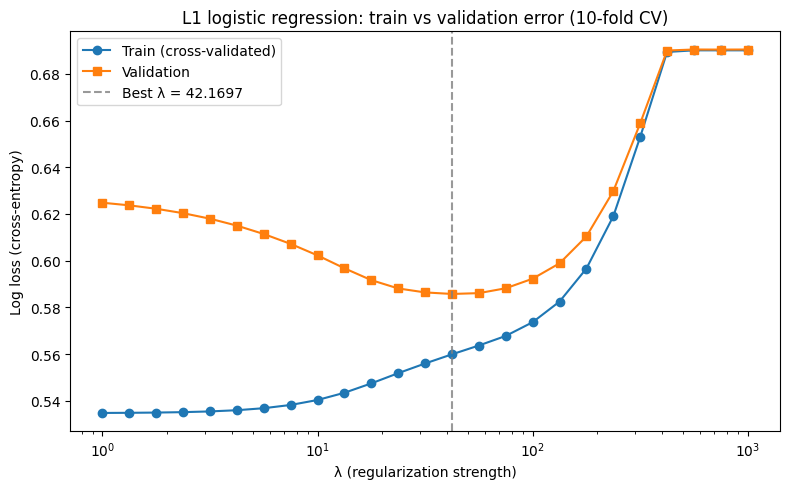

In [48]:
# --- Plot train vs validation error vs lambda ---
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(lambda_values, train_errors, "o-", label="Train (cross-validated)", color="C0")
ax.plot(lambda_values, val_errors, "s-", label="Validation", color="C1")
ax.axvline(best_lambda, color="gray", linestyle="--", alpha=0.8, label=f"Best λ = {best_lambda:.4f}")
ax.set_xlabel("λ (regularization strength)")
ax.set_ylabel("Log loss (cross-entropy)")
ax.set_title("L1 logistic regression: train vs validation error (10-fold CV)")
ax.legend()
ax.set_xscale("log")
plt.tight_layout()
plt.show()

In [49]:
# --- Refit on full training set with best C (1/best_lambda) ---
prop_model_logistic_U_lasso_cv = LogisticRegression(
    C=best_C, l1_ratio=1, solver="saga", max_iter=1000
).fit(train_df[U_cols], train_df["W"])
train_df['prop_pred_logistic_U_lasso_cv'] = prop_model_logistic_U_lasso_cv.predict_proba(train_df[U_cols])[:,1]
test_df['prop_pred_logistic_U_lasso_cv'] = prop_model_logistic_U_lasso_cv.predict_proba(test_df[U_cols])[:,1]

print(f"Best λ from CV: {best_lambda:.4f}")
print(f"Validation log loss at best λ: {val_errors[best_idx]:.4f}")

Best λ from CV: 42.1697
Validation log loss at best λ: 0.5858


In [51]:
{'training_loss': log_loss(train_df['W'], train_df['prop_pred_logistic_U_lasso']),
 'test_loss': log_loss(test_df['W'], test_df['prop_pred_logistic_U_lasso'])}

{'training_loss': 0.5512744448336946, 'test_loss': 0.6135023047081918}

In [50]:
{'training_loss': log_loss(train_df['W'], train_df['prop_pred_logistic_U_lasso_cv']),
 'test_loss': log_loss(test_df['W'], test_df['prop_pred_logistic_U_lasso_cv'])}

{'training_loss': 0.5605856153116692, 'test_loss': 0.6061288765430688}

## Random Forests

We saw in the previous lecture that the decision tree is a very useful algorithm to fit complex, non-linear functions of the features. However, letting a tree grow too large almost guarantees overfitting. In the limit, the largest possible tree creates one region per observation, leading to $0$ training bias but infeasibly large variance!

There are specific techniques to deal with this, for example tuning the maximum depth of the tree, or the minimum required observations per leaf. There are also approaches that look more like regularization, such as adding a complexity parameter that increases the loss when the tree grows larger; if the complexity is convex, then it will penalize more the larger the tree. Note that all these hyperparameters are controlling the size of the model class.

In practice, however, standalone trees are not really used anymore for prediction problems. There is an alternative tree-based algorithm that dominates single trees and there is basically no reason to use them anymore, a **Random Forest**.

According to the Cambridge Dictionary, a forest is "a large area full of trees". The "Forest" term in Random Forest comes from exactly that definition: we fit $M$ trees, with $M > 1$. However, it won't be the same tree every time, and that's where the "Random" term in the name plays its role. Random Forests are a special case of a procedure called "Bagging" (bootstrap aggregation) applied to decision trees. Given a model and a dataset, Bagging consists of generating bootstrap samples and fitting the chosen model for each sample, aggregating the results using some function like the average in regression problems or majority vote in classification problems. This increases the robustness of models that have low bias and high variance without compromising predictive power, which helps them with generalizability, as the expectation of the average of identically distributed models is the same as the expectation of individual ones.  Decision trees are the perfect candidate for Bagging, and the procedure became so prominent that became an algorithm itself.

This additional randomness stemming from the bagging procedure is certainly a step in the right direction to tackle a decision-tree's largest weakness. In fact, if we think of the trees as identically (but not necessarily independently) distributed random variables $T_m$ with variance $\sigma^2$ and pairwise correlation $\rho$, the variance of the average will be:

$$\mathbb{V}[T_m] = \rho\sigma^2 + \frac{1-\rho}{M}\sigma^2$$

However, if $\rho > 0$ the variance reduction capability of Bagging is limited by the first term, no matter how many trees we fit in our forest. To decorrelate the trees, the Random Forest algorithm also involves random feature selection for each tree $T_m$. At each step, we randomly select a number of the features to be available for splits. If the total number of available features is $p$, a typical choice for that number is $\text{round}(\sqrt{p})$.

Let's try this out using the same DGP but with a larger number of observations. One of the costs of Random Forests is computational complexity. We are fitting now $M$ models, with $M$ typically ranging between 100 and 1000. With large datasets this can become cumbersome.

In [52]:
obs_df = dgp_simulation.simulate_dgp(n=100_000, rct=False, num_perturbed_features=100, seed=42)
obs_df.shape

(100000, 306)

In [53]:
train_df, test_df = train_test_split(obs_df, test_size=0.2, random_state=42)

Recall that our decision tree was the model that seemed to work best at approximating the propensity scores. Let's use that as a benchmark.  

In [54]:
prop_model_class_tree_5 = DecisionTreeClassifier(criterion='log_loss',max_depth=5).fit(train_df[X_cols], train_df['W'])
train_df["prop_pred_class_tree_5"] = prop_model_class_tree_5.predict_proba(train_df[X_cols])[:,1]
test_df["prop_pred_class_tree_5"] = prop_model_class_tree_5.predict_proba(test_df[X_cols])[:,1]

In [55]:
{'training_loss': log_loss(train_df['W'], train_df['prop_pred_class_tree_5']),
 'test_loss': log_loss(test_df['W'], test_df['prop_pred_class_tree_5'])}

{'training_loss': 0.5728096655271272, 'test_loss': 0.5769860208571211}

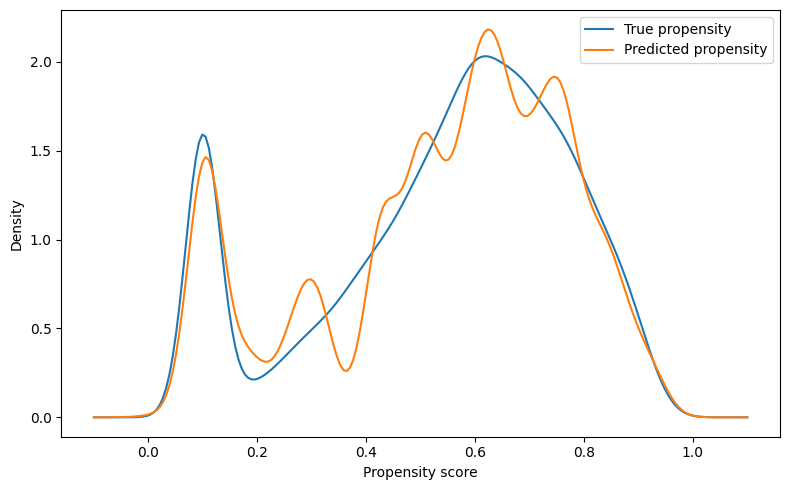

In [56]:
estimators.plot_propensities(test_df, "prop", "prop_pred_class_tree_5")

Let's try a Random Forest now.

In [57]:
params = {"n_estimators": 100, "max_depth": 5, "random_state": 42}

prop_model_rf_5 = RandomForestClassifier(**params, criterion='log_loss').fit(train_df[X_cols], train_df["W"])
train_df["prop_pred_rf_5"] = prop_model_rf_5.predict_proba(train_df[X_cols])[:, 1]
test_df["prop_pred_rf_5"] = prop_model_rf_5.predict_proba(test_df[X_cols])[:, 1]

In [58]:
{'training_loss': log_loss(train_df['W'], train_df['prop_pred_rf_5']),
 'test_loss': log_loss(test_df['W'], test_df['prop_pred_rf_5'])}

{'training_loss': 0.5809610237291316, 'test_loss': 0.5838853878436902}

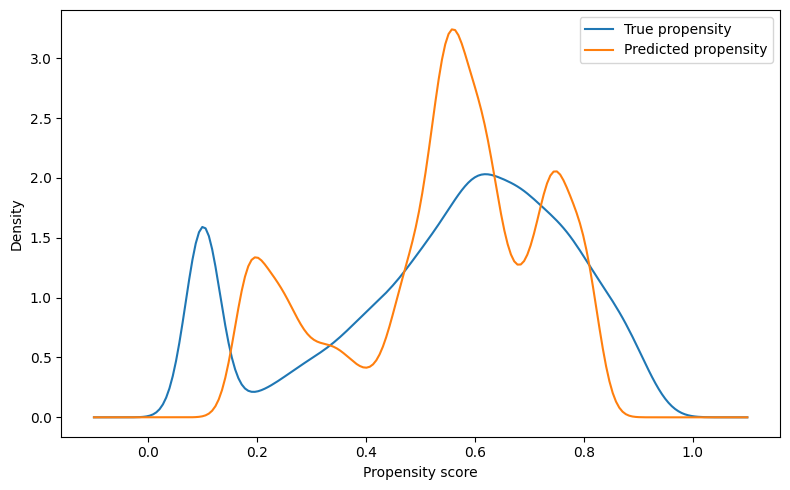

In [59]:
estimators.plot_propensities(test_df, "prop", "prop_pred_rf_5")

Let's do some manual hyperparameter tuning with the max depth of the trees:

In [60]:
prop_model_class_tree_10 = DecisionTreeClassifier(criterion='log_loss',max_depth=10).fit(train_df[X_cols], train_df['W'])
train_df["prop_pred_class_tree_10"] = prop_model_class_tree_10.predict_proba(train_df[X_cols])[:,1]
test_df["prop_pred_class_tree_10"] = prop_model_class_tree_10.predict_proba(test_df[X_cols])[:,1]

In [61]:
{'training_loss': log_loss(train_df['W'], train_df['prop_pred_class_tree_10']),
 'test_loss': log_loss(test_df['W'], test_df['prop_pred_class_tree_10'])}

{'training_loss': 0.5482673301807314, 'test_loss': 0.8636007182414}

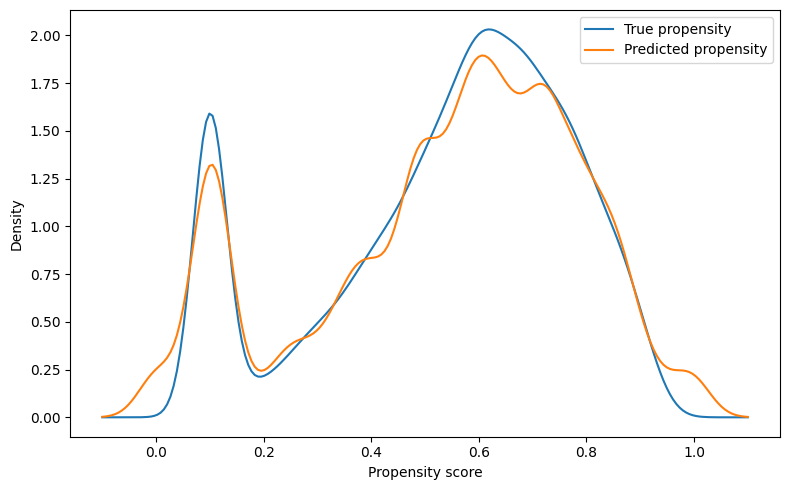

In [62]:
estimators.plot_propensities(test_df, "prop", "prop_pred_class_tree_10")

In [63]:
params = {"n_estimators": 100, "max_depth": 10, "random_state": 42}

prop_model_rf_10 = RandomForestClassifier(**params, criterion='log_loss').fit(train_df[X_cols], train_df["W"])
train_df["prop_pred_rf_10"] = prop_model_rf_10.predict_proba(train_df[X_cols])[:, 1]
test_df["prop_pred_rf_10"] = prop_model_rf_10.predict_proba(test_df[X_cols])[:, 1]

In [64]:
{'training_loss': log_loss(train_df['W'], train_df['prop_pred_rf_10']),
 'test_loss': log_loss(test_df['W'], test_df['prop_pred_rf_10'])}

{'training_loss': 0.5538729244242148, 'test_loss': 0.5734135845179246}

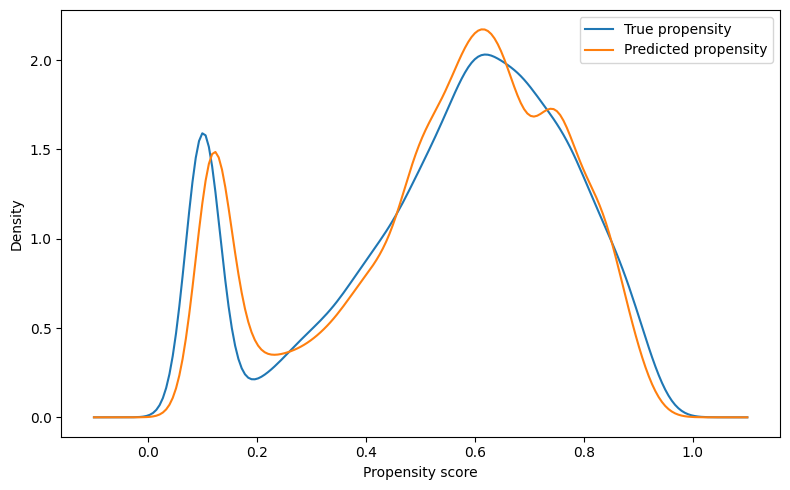

In [65]:
estimators.plot_propensities(test_df, "prop", "prop_pred_rf_10")

In [66]:
prop_model_class_tree_15 = DecisionTreeClassifier(criterion='log_loss',max_depth=15).fit(train_df[X_cols], train_df['W'])
train_df["prop_pred_class_tree_15"] = prop_model_class_tree_15.predict_proba(train_df[X_cols])[:,1]
test_df["prop_pred_class_tree_15"] = prop_model_class_tree_15.predict_proba(test_df[X_cols])[:,1]

In [67]:
{'training_loss': log_loss(train_df['W'], train_df['prop_pred_class_tree_15']),
 'test_loss': log_loss(test_df['W'], test_df['prop_pred_class_tree_15'])}

{'training_loss': 0.481305854227544, 'test_loss': 2.3546943582719324}

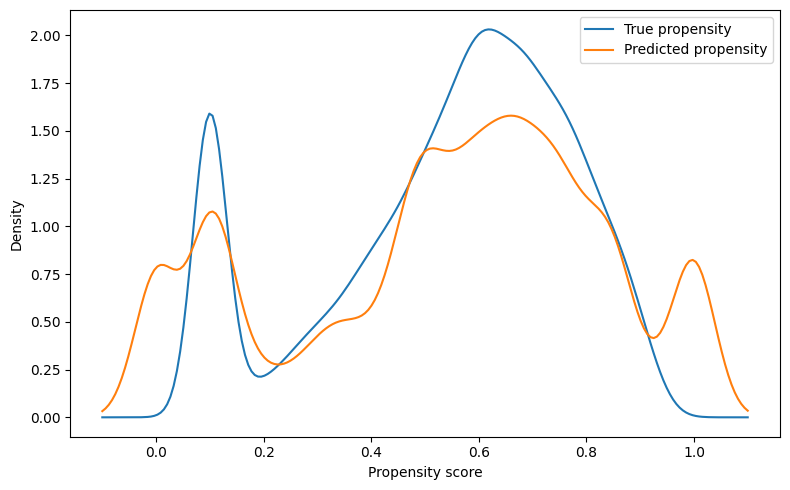

In [73]:
estimators.plot_propensities(test_df, "prop", "prop_pred_class_tree_15")

In [69]:
params = {"n_estimators": 100, "max_depth": 15, "random_state": 42}

prop_model_rf_15 = RandomForestClassifier(**params, criterion='log_loss').fit(train_df[X_cols], train_df["W"])
train_df["prop_pred_rf_15"] = prop_model_rf_15.predict_proba(train_df[X_cols])[:, 1]
test_df["prop_pred_rf_15"] = prop_model_rf_15.predict_proba(test_df[X_cols])[:, 1]

In [74]:
{'training_loss': log_loss(train_df['W'], train_df['prop_pred_rf_15']),
 'test_loss': log_loss(test_df['W'], test_df['prop_pred_rf_15'])}

{'training_loss': 0.4937935964891153, 'test_loss': 0.5758166437815995}

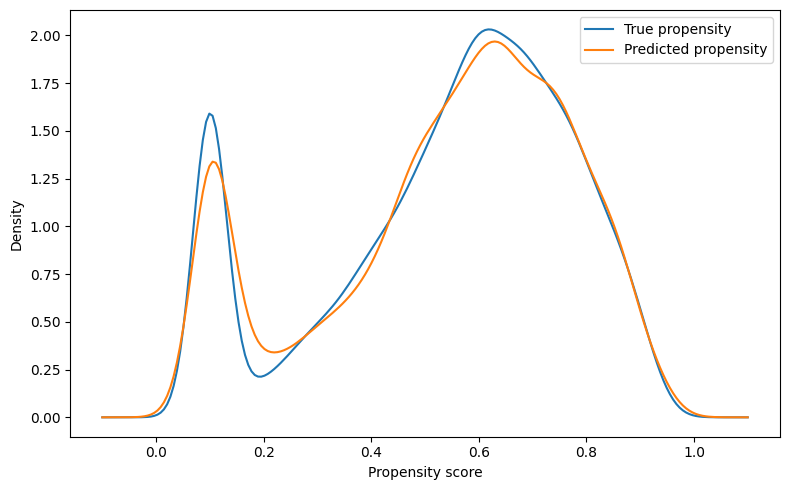

In [71]:
estimators.plot_propensities(test_df, "prop", "prop_pred_rf_15")

Let's now implement a proper cross-validation tuning of max depth to compare the best possible tree and a forest with 200 trees (holding other hyperparameters constant). This might take a while.

In [ ]:
# --- CV setup: max_depth 1..20, 5-fold ---
max_depths = np.arange(1, 21)
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
common_params = {"random_state": 42}

train_errors_tree = []
val_errors_tree = []
train_errors_forest = []
val_errors_forest = []

for max_depth in max_depths:
    fold_train_tree, fold_val_tree = [], []
    fold_train_forest, fold_val_forest = [], []
    for train_idx, val_idx in kf.split(train_df[X_cols]):
        X_fold_train = train_df[X_cols].iloc[train_idx]
        y_fold_train = train_df["W"].iloc[train_idx]
        X_fold_val = train_df[X_cols].iloc[val_idx]
        y_fold_val = train_df["W"].iloc[val_idx]

        # Single tree
        tree = DecisionTreeClassifier(max_depth=max_depth, **common_params).fit(
            X_fold_train, y_fold_train
        )
        p_train_t = tree.predict_proba(X_fold_train)[:, 1]
        p_val_t = tree.predict_proba(X_fold_val)[:, 1]
        fold_train_tree.append(log_loss(y_fold_train, p_train_t))
        fold_val_tree.append(log_loss(y_fold_val, p_val_t))

        # Forest with 100 trees (other params same as tree where applicable)
        forest = RandomForestClassifier(
            n_estimators=100, max_depth=max_depth, **common_params
        ).fit(X_fold_train, y_fold_train)
        p_train_f = forest.predict_proba(X_fold_train)[:, 1]
        p_val_f = forest.predict_proba(X_fold_val)[:, 1]
        fold_train_forest.append(log_loss(y_fold_train, p_train_f))
        fold_val_forest.append(log_loss(y_fold_val, p_val_f))

    train_errors_tree.append(np.mean(fold_train_tree))
    val_errors_tree.append(np.mean(fold_val_tree))
    train_errors_forest.append(np.mean(fold_train_forest))
    val_errors_forest.append(np.mean(fold_val_forest))

train_errors_tree = np.array(train_errors_tree)
val_errors_tree = np.array(val_errors_tree)
train_errors_forest = np.array(train_errors_forest)
val_errors_forest = np.array(val_errors_forest)

best_idx_tree = np.argmin(val_errors_tree)
best_idx_forest = np.argmin(val_errors_forest)
best_max_depth_tree = max_depths[best_idx_tree]
best_max_depth_forest = max_depths[best_idx_forest]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(max_depths, train_errors_tree, "o-", label="Train (CV)", color="C0")
ax1.plot(max_depths, val_errors_tree, "s-", label="Validation", color="C1")
ax1.axvline(
    best_max_depth_tree, color="gray", linestyle="--", alpha=0.8,
    label=f"Best max_depth = {best_max_depth_tree}",
)
ax1.set_xlabel("max_depth")
ax1.set_ylabel("Log loss (cross-entropy)")
ax1.set_title("Single tree: train vs validation error (10-fold CV)")
ax1.legend()
ax1.set_xticks(max_depths)

ax2.plot(max_depths, train_errors_forest, "o-", label="Train (CV)", color="C0")
ax2.plot(max_depths, val_errors_forest, "s-", label="Validation", color="C1")
ax2.axvline(
    best_max_depth_forest, color="gray", linestyle="--", alpha=0.8,
    label=f"Best max_depth = {best_max_depth_forest}",
)
ax2.set_xlabel("max_depth")
ax2.set_ylabel("Log loss (cross-entropy)")
ax2.set_title("Random forest (100 trees): train vs validation error (5-fold CV)")
ax2.legend()
ax2.set_xticks(max_depths)

plt.tight_layout()
plt.show()

In [ ]:
prop_model_tree_cv = DecisionTreeClassifier(
    max_depth=best_max_depth_tree, **common_params
).fit(train_df[X_cols], train_df["W"])
prop_model_forest_cv = RandomForestClassifier(
    n_estimators=100, max_depth=best_max_depth_forest, **common_params
).fit(train_df[X_cols], train_df["W"])

train_df["prop_pred_tree_cv"] = prop_model_tree_cv.predict_proba(train_df[X_cols])[:, 1]
test_df["prop_pred_tree_cv"] = prop_model_tree_cv.predict_proba(test_df[X_cols])[:, 1]
train_df["prop_pred_forest_cv"] = prop_model_forest_cv.predict_proba(train_df[X_cols])[:, 1]
test_df["prop_pred_forest_cv"] = prop_model_forest_cv.predict_proba(test_df[X_cols])[:, 1]

print(f"Best max_depth (tree):   {best_max_depth_tree}")
print(f"Best max_depth (forest): {best_max_depth_forest}")

In [ ]:
{'training_loss': log_loss(train_df['W'], train_df['prop_pred_tree_cv']),
 'test_loss': log_loss(test_df['W'], test_df['prop_pred_tree_cv'])}

In [ ]:
{'training_loss': log_loss(train_df['W'], train_df['prop_pred_forest_cv']),
 'test_loss': log_loss(test_df['W'], test_df['prop_pred_forest_cv'])}

In [ ]:
estimators.plot_propensities(test_df, "prop", "prop_pred_tree_cv")

In [ ]:
estimators.plot_propensities(test_df, "prop", "prop_pred_forest_cv")

In [75]:
estimators.ipw_estimator(test_df, propensity_col='prop_pred_class_tree_5')

{'estimate': 0.27655269794391735,
 'std_error': 0.03222350378451606,
 'ci_95': [0.2133946305262659, 0.3397107653615688],
 'ci_size_perc': 45.67524951823786,
 'p_value': 9.29716067605318e-18}

In [76]:
estimators.ipw_estimator(test_df, propensity_col='prop_pred_rf_15')

{'estimate': 0.2615647437966843,
 'std_error': 0.0326321345462193,
 'ci_95': [0.19760576008609448, 0.32552372750727415],
 'ci_size_perc': 48.90489657146262,
 'p_value': 1.0963875080107451e-15}

## Feature Importance and Partial Dependence Plots

Aside from computational complexity, the other thing we sacrifice with Random Forests is interpretability. In other words, it is not straight-forward to know how our features actually predict the target according to our model. In parametric models like Linear and Logistic Regression, we get that immediately from the coefficients. The sign of the coefficient for $X_{ij}$ tells us the sign of the relationship between $X_j$ and the predictions $\hat{f}(X)$. In Linear Regression, it even tells us the exact relationship between $X_j$ and $\hat{f}(X)$. The case of decision trees is a bit more complicated, but one can visualize the trees and follow the path of an observation $X_i = x$ along the tree until its final node.

In Random Forests, things become more complicated. We don't have a single tree anymore, so any attempt at visualizing relationships like in a single decision tree is infeasible in terms of interpretability. Trees are non-parametric, so we don't have any parameter estimates that could help interpret the results.

But there are several things we can do to get an idea of how our features affect the predictions. One of them is called **Feature Importance** analysis, and tries to answer the question: "How important is the feature $X_j$ in determining the predictions $\hat{f}(X)$? There are a number of ways to compute feature importance for a Random Forest, but they all involve measuring either how frequent feature $X_j$ was chosen by the algorithm to do a split, how meaningful the splits were in terms of loss reduction. Methods to compute this typically come in the same libraries as the algorithms. 

Let's fit a Random Forest with the $X_j$ and the noisy $U_j$ to visualize the feature importance.

In [77]:
params = {"n_estimators": 100, "max_depth": 15, "random_state": 42}

prop_model_rf_U_X = RandomForestClassifier(**params, criterion='log_loss').fit(train_df[X_cols + U_cols], train_df["W"])
train_df["prop_pred_rf_U_X"] = prop_model_rf_U_X.predict_proba(train_df[X_cols + U_cols])[:, 1]
test_df["prop_pred_rf_U_X"] = prop_model_rf_U_X.predict_proba(test_df[X_cols + U_cols])[:, 1]

In [78]:
{'training_loss': log_loss(train_df['W'], train_df['prop_pred_rf_U_X']),
 'test_loss': log_loss(test_df['W'], test_df['prop_pred_rf_U_X'])}

{'training_loss': 0.307558683226401, 'test_loss': 0.58285594508213}

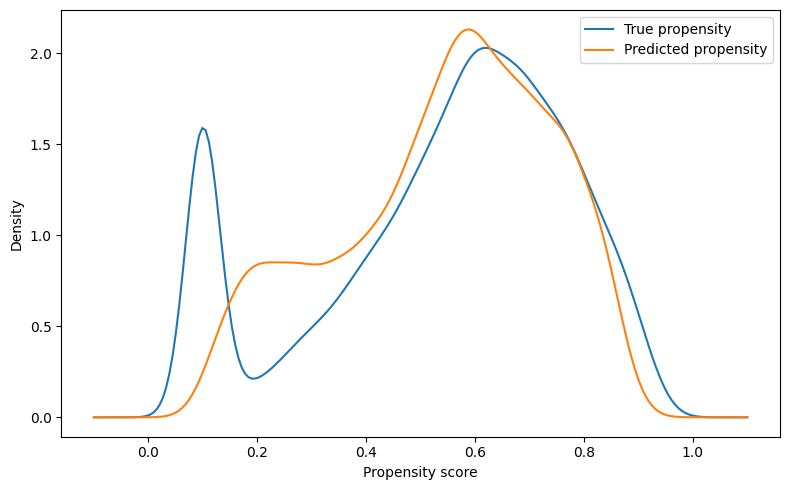

In [79]:
estimators.plot_propensities(test_df, "prop", "prop_pred_rf_U_X")

In [80]:
prop_model_rf_U_X.feature_importances_

array([0.00172908, 0.03169009, 0.03507757, 0.00224791, 0.00221338,
       0.00218525, 0.00215233, 0.00228663, 0.00224338, 0.00235232,
       0.00210298, 0.00218442, 0.00222491, 0.00242871, 0.0021646 ,
       0.00211635, 0.00227685, 0.00224717, 0.00225567, 0.0021847 ,
       0.00218597, 0.00220416, 0.0022412 , 0.00210395, 0.00222509,
       0.00237337, 0.00219412, 0.00226299, 0.00218221, 0.00224054,
       0.00218741, 0.00225643, 0.00215456, 0.00230575, 0.00220082,
       0.00221088, 0.00222288, 0.00225529, 0.0022958 , 0.00218258,
       0.002218  , 0.00224617, 0.00227613, 0.00222827, 0.00219835,
       0.00235749, 0.00220398, 0.00218193, 0.00223489, 0.00228347,
       0.00212212, 0.00221682, 0.00227766, 0.00217624, 0.00225118,
       0.0022101 , 0.0022154 , 0.00242871, 0.00218292, 0.00223308,
       0.00226711, 0.00234119, 0.00218052, 0.00235325, 0.00228222,
       0.00222278, 0.00225981, 0.00240309, 0.0024007 , 0.002302  ,
       0.00222967, 0.00222391, 0.00232763, 0.00227488, 0.00224

In [81]:
imp = pd.Series(
    prop_model_rf_U_X.feature_importances_,
    index=X_cols+U_cols
).sort_values(ascending=False)
print(imp.head(5))
print(imp.tail(5))

X3       0.035078
X2       0.031690
U2_23    0.005432
U3_16    0.004976
U2_17    0.004865
dtype: float64
U1_48    0.002122
U1_13    0.002116
U1_21    0.002104
U1_8     0.002103
X1       0.001729
dtype: float64


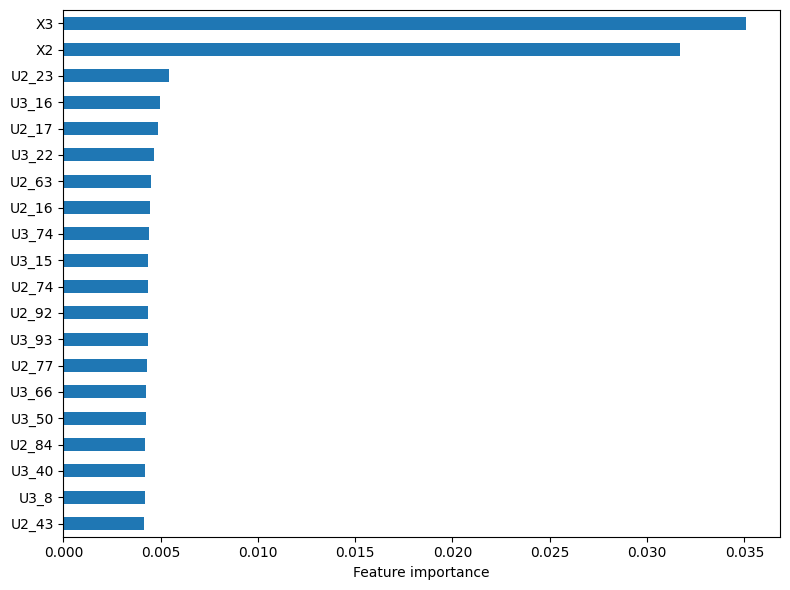

In [82]:
top_k = 20
imp.sort_values(ascending=True).tail(top_k).plot.barh(figsize=(8, 6))
plt.xlabel("Feature importance")
plt.tight_layout()
plt.show()

As expected, $X_2$ and $X_3$ appear much more important than the noise variables. However, we also see that the trees are splitting at the $U_{2p}$ and $U_{3p}$ and overfitting to the training set, which is why we see that big gap between the training and test set loss values. Because it is meaningful only as a relative measure, Feature Importance is usually normalized to sum to 1.

Now, feature importance tells us how relevant a feature is in our algorithm, but does not tell us anything about the sign of the relationship between the feature and the predictions. To try to visualize that relationship, we can resort to **Partial Dependence Plots** (PDP). A PDP plot is an attempt to visualize the partial derivatives of $\hat{f}(X)$. To construct the PDP for a feature $X_j$, we construct a grid of the values $x$ that $X_j$ can take (or those we care about), and for each $x$, we fix the value of $X_j$ in our dataset to $x$, compute $\hat{f}(X_{-j},x)$ and aggregate the predictions, typically with the average (so we estimate the expected partial derivatives). As in the case of Feature Importance, there are libraries that help us compute PDPs from the most common models.

Let's fit visualize the PDPs for $X_2$ and $X_3$ using a model without the $U_j$.

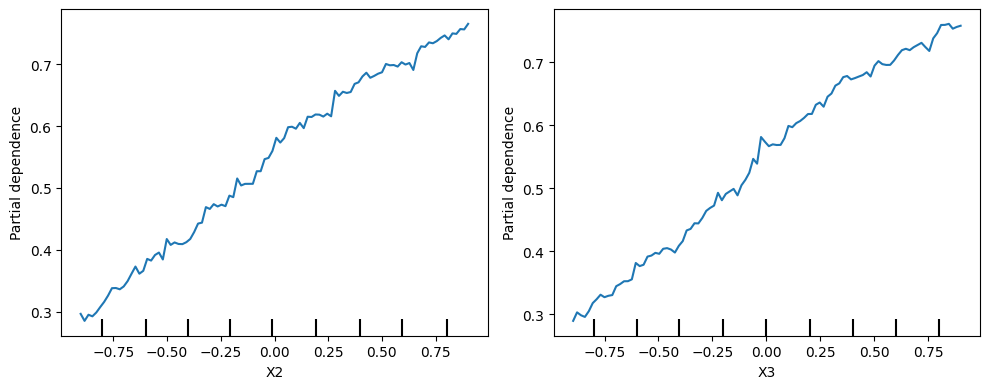

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, feat in zip(axes, ["X2", "X3"]):
    PartialDependenceDisplay.from_estimator(
        prop_model_rf_15,
        test_df[X_cols],
        features=[feat],
        ax=ax,
        kind="average",
    )
plt.tight_layout()
plt.show()

What should we get if we plot the PDP for $X_1$?

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
PartialDependenceDisplay.from_estimator(
    prop_model_rf_15,
    test_df[X_cols],
    features=["X1"],
    ax=ax,
    kind="average",
)
plt.tight_layout()
plt.show()

It is important to note that the PDP for $X_j$ is truly valid only if the features that remain constant are independent of $X_j$. In the cases above, all the $X_j$ are independent, so the PDPs truly reflect how the prediction changes on average as we change the $X_j$. But if this is not the case, then we need to adjust our procedure to account for that. One way to do this is to let the dependent block of features vary jointly. That is, if $X_j$ and $X_k$ are not independent, we plot a PDP letting both vary at the same time. However, this gets very complex extremely quickly, so going beyond a two-way PDP is infeasible (and practically impossible to visualize). Let's try the two-way plot for $X_2$ and $X_3$. Note this will take a _very_ long time.

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
PartialDependenceDisplay.from_estimator(
    prop_model_rf_15,
    test_df[X_cols],
    features=[("X2","X3")],
    ax=ax,
    kind="average",
)
plt.tight_layout()
plt.show()

Because of the computational cost, this limitation is usually simply accepted when we analyzing PDPs and we should bring domain knowledge to help interpret them in the presence of correlated variables.